In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data_fold = "../../../data/carla_sim/random_spawn"
exp_fold = "../../../data/experiments/carla_sim/random_spawn"

In [3]:
WIDTH, HEIGHT = 640, 480

N_SUBDIV_X = 2
N_SUBDIV_Y = 2
SUBDIV_WIDTH, SUBDIV_HEIGHT = WIDTH // N_SUBDIV_X, HEIGHT // N_SUBDIV_Y
N_DISCARD_TOP = 1
N_DISCARD_BOTTOM = 1
N_DISCARD_LEFT = 1
N_DISCARD_RIGHT = 1

T_STEPS = 200

T_STEPS_T_COLL_MAX = 100  # number of time steps before collision to consider as a positive output if a collision occurs in the sequence

In [5]:
class SigmoidScaleBias(nn.Module):
    def __init__(self, dim, scale=True, bias=True, single_param=False):
        super().__init__()
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1 if single_param else dim))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)
        if scale:
            self.scale = nn.Parameter(torch.Tensor(1 if single_param else dim))
        else:
            self.register_parameter('scale', None)
        
        if self.bias is not None:
            self.bias.data.uniform_(0, 0)

        if self.scale is not None:
            self.scale.data.uniform_(1, 1)

    def forward(self, input):
        output = input
        if self.scale is not None:
            output *= self.scale.unsqueeze(0).expand_as(output)
        if self.bias is not None:
            output -= self.bias.unsqueeze(0).expand_as(output)
        return torch.sigmoid(output)

In [6]:
class Net(nn.Module):
    def __init__(
        self,
        width=SUBDIV_WIDTH,
        height=SUBDIV_HEIGHT,
        kern_half_size=3,
        rmo_head=True,
        sigm_kern=0.3,
        reg=1.5,
        dt=10.0,
        r_out_sigm_scale=500.0,
        r_out_scale=500.0,
        train_weights=True,
        size_layers=[10],
        use_dropout=False,
        train_kernels=False,
    ):
        super().__init__()

        self.width = width
        self.height = height
        self.kern_half_size = kern_half_size
        self.size_layers = (
            size_layers if isinstance(size_layers, list) else [size_layers]
        )
        self.kern_size = 2 * kern_half_size + 1

        self.sigm_kern = sigm_kern

        self.reg = reg

        self.dt = dt

        self.train_weights = train_weights

        self.rmo_head = rmo_head
        self.use_dropout = use_dropout

        _x, _y = np.meshgrid(
            np.arange(-kern_half_size, kern_half_size + 1),
            np.arange(-kern_half_size, kern_half_size + 1),
        )

        self.kern_x = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_y = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_norm = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        _gauss = np.exp(-(_x**2 + _y**2) / (2.0 * (sigm_kern * kern_half_size) ** 2))
        _gauss /= _gauss.sum()

        with torch.no_grad():
            self.kern_norm.weight.data = nn.Parameter(
                torch.tensor(_gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_norm.weight.requires_grad = train_kernels

            self.kern_x.weight.data = nn.Parameter(
                torch.tensor(_x * _gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_x.weight.requires_grad = train_kernels

            self.kern_y.weight.data = nn.Parameter(
                torch.tensor(_y * _gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_y.weight.requires_grad = train_kernels

        self.vx = torch.zeros((1, 1, height, width)).float()
        self.vy = torch.zeros((1, 1, height, width)).float()

        _x, _y = np.meshgrid(
            np.linspace(-1, 1, width),
            np.linspace(-height / width, height / width, height),
        )

        with torch.no_grad():
            #if not self.train_weights:
            self.wx = nn.Parameter(
                torch.tensor(_x).float().unsqueeze(0).unsqueeze(0)
            )
            self.wy = nn.Parameter(
                torch.tensor(_y).float().unsqueeze(0).unsqueeze(0)
            )
            '''
            else:
                self.wx = nn.Parameter(
                    torch.ones((1, 1, height, width))
                )
                self.wy = nn.Parameter(
                    torch.ones((1, 1, height, width))
                )
            '''
            self.wx.requires_grad = False#self.train_weights
            self.wy.requires_grad = False#self.train_weights

            # self.wx = nn.Parameter(torch.zeros((1, 1, height, width)))
            # self.wy = nn.Parameter(torch.zeros((1, 1, height, width)))

        self.fwd = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width * height, 2, bias=False),
        )

        with torch.no_grad():
            if not self.train_weights:
                w_pos = np.exp(-(_x**2.0) / (2.0 * 0.25**2)) * np.exp(
                    -(_y**2.0) / (2.0 * 0.25**2)
                )
                w_pos_left = np.zeros_like(w_pos)
                w_pos_left[:, : width // 2] = w_pos[:, : width // 2]
                w_pos_right = np.zeros_like(w_pos)
                w_pos_right[:, width // 2 :] = w_pos[:, width // 2 :]

                self.fwd[1].weight.data[0] = nn.Parameter(
                    torch.tensor(w_pos_left.flatten()).float()
                )
                self.fwd[1].weight.data[1] = nn.Parameter(
                    torch.tensor(w_pos_right.flatten()).float()
                )
            else:
                self.fwd[1].weight.data = nn.Parameter(
                    torch.zeros((2, width * height)).float()
                )

            self.fwd[1].weight.requires_grad = self.train_weights

        self.sigm = SigmoidScaleBias(2, single_param=True)

        with torch.no_grad():
            self.sigm.scale = nn.Parameter(torch.tensor([r_out_sigm_scale]).float())

        self.out_scale = nn.Parameter(torch.tensor([r_out_scale]).float())

        self.out_th = nn.Parameter(torch.zeros((1)).float())

        if self.use_dropout:
            self.dropout = nn.Dropout(self.use_dropout)

    def forward(self, x):
        x_p = (x > 0).float()
        x_n = (x < 0).float()

        if self.use_dropout:
            x_p = self.dropout(x_p)
            x_n = self.dropout(x_n)

        I_x_p_prev = self.kern_x(x_p[..., 0:1, :, :])
        I_y_p_prev = self.kern_y(x_p[..., 0:1, :, :])
        I_norm_p_prev = self.kern_norm(x_p[..., 0:1, :, :])

        vx_p = (
            -x_p[..., 1:2, :, :]
            * I_x_p_prev
            * self.dt
            / (self.reg**2 + I_norm_p_prev * self.dt**2)
        )
        vy_p = (
            -x_p[..., 1:2, :, :]
            * I_y_p_prev
            * self.dt
            / (self.reg**2 + I_norm_p_prev * self.dt**2)
        )

        I_x_n_prev = self.kern_x(x_n[..., 0:1, :, :])
        I_y_n_prev = self.kern_y(x_n[..., 0:1, :, :])
        I_norm_n_prev = self.kern_norm(x_n[..., 0:1, :, :])

        vx_n = (
            -x_n[..., 1:2, :, :]
            * I_x_n_prev
            * self.dt
            / (self.reg**2 + I_norm_n_prev * self.dt**2)
        )
        vy_n = (
            -x_n[..., 1:2, :, :]
            * I_y_n_prev
            * self.dt
            / (self.reg**2 + I_norm_n_prev * self.dt**2)
        )

        self.vx = vx_p + vx_n
        self.vy = vy_p + vy_n

        v_project = self.vx * self.wx + self.vy * self.wy

        left_right = self.fwd(v_project)

        if self.rmo_head:
            out = (
                self.out_scale
                * torch.min(left_right, dim=1).values
                * torch.prod(self.sigm(left_right), dim=1)
                - self.out_th
            )
        else:
            out = self.out_scale * left_right.mean(dim=1) - self.out_th

        return out

In [7]:
def load_metadata(fold, t_steps):
    samples = [f for f in os.listdir(fold) if f.startswith("example")]
    samples.sort(key=lambda x: int(x.split("_")[1]))

    labels = []
    metadata = []

    samples_filtered = []

    for sample in samples:
        metadat = np.load(os.path.join(fold, sample, "sim_data.npz"), allow_pickle=True)

        sample_steps = int(metadat["t_end"] // metadat["dt"])

        if sample_steps < t_steps:
            continue
        
        samples_filtered.append(sample)

        labels.append(int(not metadat["coll_type"][()].startswith("none")))

        metadata.append(
            {
                "coll_type": metadat["coll_type"][()],
                "t_end_ms": metadat["t_end"][()],
                "dt": metadat["dt"][()],
                "vel": metadat["vel"][()],
                "diam": metadat["diameter_object"][()],
            }
        )
    
    return samples_filtered, labels, metadata

In [8]:
smpls, lbls, md = load_metadata(data_fold, T_STEPS)

types, counts = np.unique([m["coll_type"] for m in md], return_counts=True)
type_counts = dict(zip(list(types), list(counts)))

print(type_counts)

{'cars': 251, 'none': 294, 'none_with_crossing': 175, 'none_with_traffic': 167, 'pedestrians': 251}


In [11]:
N_SAMPLES = 1000

# desired proportion of collision types:
# 25% cars, 25% pedestrians, %25 none, 25% none with crossing

# check if we have enough samples for each type
assert N_SAMPLES // 4 <= type_counts["cars"]
assert N_SAMPLES // 4 <= type_counts["pedestrians"]
assert N_SAMPLES // 6 <= type_counts["none"]
assert N_SAMPLES // 6 <= type_counts["none_with_crossing"]
assert N_SAMPLES // 6 <= type_counts["none_with_traffic"]

In [16]:
inds_cars = np.where(np.array([m["coll_type"] for m in md]) == "cars")[0]
inds_pedestrians = np.where(np.array([m["coll_type"] for m in md]) == "pedestrians")[0]
inds_none = np.where(np.array([m["coll_type"] for m in md]) == "none")[0]
inds_none_with_crossing = np.where(np.array([m["coll_type"] for m in md]) == "none_with_crossing")[0]
inds_none_with_traffic = np.where(np.array([m["coll_type"] for m in md]) == "none_with_traffic")[0]

np.random.shuffle(inds_cars)
np.random.shuffle(inds_pedestrians)
np.random.shuffle(inds_none)
np.random.shuffle(inds_none_with_crossing)
np.random.shuffle(inds_none_with_traffic)

inds = list(inds_cars[:N_SAMPLES // 4])
inds.extend(list(inds_pedestrians[:N_SAMPLES // 4]))
inds.extend(list(inds_none[:N_SAMPLES // 6]))
inds.extend(list(inds_none_with_crossing[:N_SAMPLES // 6]))
# fill the remaining samples with none_with_traffic
inds.extend(list(inds_none_with_traffic[:N_SAMPLES - len(inds)]))

np.random.shuffle(inds)

N_TRAIN = int(0.15 * N_SAMPLES)
N_VAL = int(0.15 * N_SAMPLES)
N_TEST = N_SAMPLES - N_TRAIN - N_VAL

smpls_train = [smpls[i] for i in inds[:N_TRAIN]]
smpls_val = [smpls[i] for i in inds[N_TRAIN:N_TRAIN + N_VAL]]
smpls_test = [smpls[i] for i in inds[N_TRAIN + N_VAL:N_SAMPLES]]

np.save(os.path.join(exp_fold, "idxs.npy"), inds)

np.savez(os.path.join(exp_fold, "samples.npz"), train=smpls_train, val=smpls_val, test=smpls_test)

In [13]:
def load_raw_data(fold, samples):
    labels = []
    metadata = []
    data = []

    mem_gb = 0

    for sample in samples:
        events = np.load(os.path.join(fold, sample, "events.npy"))
        metadat = np.load(os.path.join(fold, sample, "sim_data.npz"), allow_pickle=True)

        labels.append(int(not metadat["coll_type"][()].startswith("none")))

        data.append(events)

        mem_gb += events.nbytes / 1e9
        print(f"Total estimate of event data size: {mem_gb:.2f} GB", end="\r")

        metadata.append(
            {
                "coll_type": metadat["coll_type"][()],
                "t_end_ms": metadat["t_end"][()],
                "dt": metadat["dt"][()],
                "vel": metadat["vel"][()],
                "diam": metadat["diameter_object"][()],
            }
        )
    
    return data, labels, metadata

In [17]:
data_train, lbls_train, md_train = load_raw_data(data_fold, smpls_train)
data_val, lbls_val, md_val = load_raw_data(data_fold, smpls_val)
#data_test, lbls_test, md_test = load_raw_data(data_fold, smpls_test)

In [18]:
def convert_to_tens(data, labels, metadata, t_steps):
    X = []

    idx_drop = []
    for i, events in tqdm(enumerate(data)):
        dt = metadata[i]["dt"]
        t_end = metadata[i]["t_end_ms"]
        nt = int(t_end / dt)
        if nt < t_steps:
            idx_drop.append(i)
            print(f"Sample {i} has too few frames, dropping it.")
            continue
        _dat = torch.zeros(t_steps, SUBDIV_HEIGHT, SUBDIV_WIDTH).type(torch.int8)

        # if it is any other than none_with_crossing, start at idx so that we end with the end of the sequence
        # if it is none_with_crossing, we center around the middle of the sequence, because the object is at the center
        # of the frame roughly at the middle of the sequence
        if metadata[i]["coll_type"] != "none_with_crossing":
            t_offset = nt - t_steps
        else:
            t_offset = (nt - t_steps) // 2
        for t in tqdm(range(t_steps), leave=False):
            _evts = events[
                (events["t"] >= (t + t_offset) * dt)
                & (events["t"] < (t + 1 + t_offset) * dt)
                & (events["y"] >= N_DISCARD_TOP * SUBDIV_HEIGHT // 2)
                & (events["y"] < HEIGHT - N_DISCARD_BOTTOM * SUBDIV_HEIGHT // 2)
                & (events["x"] >= N_DISCARD_LEFT * SUBDIV_WIDTH // 2)
                & (events["x"] < WIDTH - N_DISCARD_RIGHT * SUBDIV_WIDTH // 2)
            ]
            _dat[
                t,
                _evts["y"] - N_DISCARD_TOP * SUBDIV_HEIGHT // 2,
                _evts["x"] - N_DISCARD_LEFT * SUBDIV_WIDTH // 2,
            ] = torch.tensor(2 * _evts["p"].astype(int) - 1).type(torch.int8)
        X.append(_dat)

    X = torch.stack(X)

    labels = torch.tensor(
        [labels[i] for i in range(len(labels)) if i not in idx_drop]
    ).type(torch.int8)
    metadata = [metadata[i] for i in range(len(metadata)) if i not in idx_drop]

    return X, labels, metadata

In [19]:
X_train, y_train, md_train = convert_to_tens(data_train, lbls_train, md_train, T_STEPS)
assert len(lbls_train) == len(y_train)
X_val, y_val, md_val = convert_to_tens(data_val, lbls_val, md_val, T_STEPS)
assert len(lbls_val) == len(y_val)
#X_test, y_test, md_test = convert_to_tens(data_test, lbls_test, md_test, T_STEPS)
#assert len(lbls_test) == len(y_test)

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
try:
    torch.save(X_train, os.path.join(exp_fold, "X_train.pt"))
    torch.save(y_train, os.path.join(exp_fold, "y_train.pt"))
    torch.save(md_train, os.path.join(exp_fold, "md_train.pt"))

    torch.save(X_val, os.path.join(exp_fold, "X_val.pt"))
    torch.save(y_val, os.path.join(exp_fold, "y_val.pt"))
    torch.save(md_val, os.path.join(exp_fold, "md_val.pt"))

    #torch.save(X_test, os.path.join(exp_fold, "X_test.pt"))
    #torch.save(y_test, os.path.join(exp_fold, "y_test.pt"))
    #torch.save(md_test, os.path.join(exp_fold, "md_test.pt"))
except Exception as e:
    print(e)

In [22]:
X_train = torch.load(os.path.join(exp_fold, "X_train.pt"))
X_val = torch.load(os.path.join(exp_fold, "X_val.pt"))
#X_test = torch.load(os.path.join(exp_fold, "X_test.pt"))

y_train = torch.load(os.path.join(exp_fold, "y_train.pt"))
y_val = torch.load(os.path.join(exp_fold, "y_val.pt"))
#y_test = torch.load(os.path.join(exp_fold, "y_test.pt"))

md_train = torch.load(os.path.join(exp_fold, "md_train.pt"))
md_val = torch.load(os.path.join(exp_fold, "md_val.pt"))
#md_test = torch.load(os.path.join(exp_fold, "md_test.pt")

/tmp/ipykernel_1290344/3477848559.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load(os.path.join(exp_fold, "X_train.pt"))
/tmp/ipykernel_1290344/34778

In [10]:
def gen_x_sequ(X, Y, t_steps_to_coll_max=None):
    _t_steps = X.shape[1]
    X_1 = X[:,1:,...]
    X_0 = X[:,:-1,...]
    X_seq = torch.stack([X_0, X_1], dim=2)
    X_seq = X_seq.view(-1, X_seq.shape[-3], X_seq.shape[-2], X_seq.shape[-1])
    
    Y_expand = Y.unsqueeze(1).repeat(1,_t_steps-1)#.flatten()
    if t_steps_to_coll_max is not None:
        Y_expand[:,:-t_steps_to_coll_max] = 0
    Y_expand = Y_expand.flatten()

    return X_seq, Y_expand

In [11]:
X_seq_train, y_seq_train = gen_x_sequ(X_train, y_train, T_STEPS_T_COLL_MAX)
X_seq_val, y_seq_val = gen_x_sequ(X_val, y_val, T_STEPS_T_COLL_MAX)
#X_seq_test, y_seq_test = gen_x_sequ(X_test, y_test, T_STEPS_T_COLL_MAX)

In [12]:
# create dataloaders

train_data = torch.utils.data.TensorDataset(X_seq_train, y_seq_train)
val_data = torch.utils.data.TensorDataset(X_seq_val, y_seq_val)
#test_data = torch.utils.data.TensorDataset(X_seq_test, y_seq_test)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### First, only train hyperparameters

In [15]:
loss_fn = nn.BCEWithLogitsLoss()

N_EPOCHS = 20

hyperparams = {}

for mode in ["rmo", "linear"]:

    print(f"Mode {mode}")
    net = Net(
        kern_half_size=2,
        sigm_kern=0.3,
        reg=0.1,
        r_out_sigm_scale=1.0,
        r_out_scale=1.0,
        size_layers=[],
        rmo_head=(mode == "rmo"),
        use_dropout=0.5,
        train_kernels=False,
        train_weights=False,
    )
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(N_EPOCHS):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = loss_fn(outputs.flatten(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                val_loss += loss_fn(outputs.flatten(), labels.float()).item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Validation loss: {val_loss / len(val_loader)}")

    hyperparams[mode] = {
        "sigm_bias": net.sigm.bias.detach().cpu().numpy()[0],
        "sigm_scale": net.sigm.scale.detach().cpu().numpy()[0],
        "out_scale": net.out_scale.detach().cpu().numpy()[0],
        "out_th": net.out_th.detach().cpu().numpy()[0],
    }

    # save network state
    torch.save(net.state_dict(), os.path.join(exp_fold, f"net_state_dict_hyperparam_train_{mode}.pt"))

Mode rmo
Epoch 1, loss: 0.5066506885000108
Validation loss: 0.4255209349471457
Epoch 2, loss: 0.3672471378010569
Validation loss: 0.34340900880380715
Epoch 3, loss: 0.3153982303980718
Validation loss: 0.3109054424580347
Epoch 4, loss: 0.2939830433661148
Validation loss: 0.2970125415911066
Epoch 5, loss: 0.2852365153203823
Validation loss: 0.2915289377234386
Epoch 6, loss: 0.2815348771974716
Validation loss: 0.2889065048915077
Epoch 7, loss: 0.2806532585480333
Validation loss: 0.2878874287734275
Epoch 8, loss: 0.2795885806346246
Validation loss: 0.2874486503742134
Epoch 9, loss: 0.27808669562444555
Validation loss: 0.2871940411699573
Epoch 10, loss: 0.27848836564781326
Validation loss: 0.28710636148333263
Epoch 11, loss: 0.2782511955081203
Validation loss: 0.2870604807550092
Epoch 12, loss: 0.2775664868957232
Validation loss: 0.28716306418868537
Epoch 13, loss: 0.27821867625525526
Validation loss: 0.2870911239832844
Epoch 14, loss: 0.2767685658846446
Validation loss: 0.2871622179137616


In [16]:
# test the model

net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        predicted = (outputs > 0).int()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the validation set: {100 * correct / total}%")

Accuracy of the network on the validation set: 87.51758793969849%


In [18]:
df_hyperparams = pd.DataFrame(hyperparams)

In [19]:
df_hyperparams

,rmo,linear
sigm_bias,-2.565055,0.000000
sigm_scale,1.547136,1.000000
out_scale,1.765281,1.105037
out_th,2.736443,2.932026


In [30]:
# save parameters to csv
df_hyperparams.to_csv(os.path.join(exp_fold, "opt_hyperparams.csv"))

In [66]:
loss_fn = nn.BCEWithLogitsLoss()

N_RUNS = 50

N_EPOCHS = 20

projection_weights = {"rmo": [], "linear": []}

for mode in ["rmo", "linear"]:

    for i in range(N_RUNS):
        print(f"Run {i + 1}", end="\r")
        net = Net(
            kern_half_size=2,
            sigm_kern=0.3,
            reg=0.1,
            r_out_sigm_scale=1.0,
            r_out_scale=1.0,
            size_layers=[],
            rmo_head=(mode == "rmo"),
            use_dropout=0.5,
            train_kernels=False,
            train_weights=True,
        )
        net.to(device)

        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

        train_losses = []
        val_losses = []

        for epoch in range(N_EPOCHS):
            net.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = net(inputs)

                loss = loss_fn(outputs.flatten(), labels.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            train_losses.append(running_loss / len(train_loader))

            #print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

            net.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = net(inputs)
                    val_loss += loss_fn(outputs.flatten(), labels.float()).item()

            val_losses.append(val_loss / len(val_loader))
            #print(f"Validation loss: {val_loss / len(val_loader)}")

        projection_weights[mode].append(net.fwd[1].weight.detach().cpu().numpy())

    projection_weights[mode] = np.array(projection_weights[mode])
    projection_weights[mode] = projection_weights[mode].reshape(-1, 2, SUBDIV_HEIGHT, SUBDIV_WIDTH)

In [8]:
#np.savez(os.path.join(exp_fold, "projection_weights.npz"), **projection_weights)

In [5]:
projection_weights = dict(np.load(os.path.join(exp_fold, "projection_weights.npz")))

assert projection_weights["rmo"].shape == projection_weights["linear"].shape

N_RUNS = projection_weights["rmo"].shape[0]
SUBDIV_HEIGHT = projection_weights["rmo"].shape[2]
SUBDIV_WIDTH = projection_weights["rmo"].shape[3]

In [6]:
inertia = {}
silhouette = {}

k_max = 8

for mode in ["rmo", "linear"]:

    _projection_weights_kmeans = projection_weights[mode].reshape(-1, 2 * SUBDIV_HEIGHT * SUBDIV_WIDTH)

    kmeans = KMeans(n_clusters=1, init='random')
    kmeans.fit(_projection_weights_kmeans)

    inertia[mode] = [kmeans.inertia_ / N_RUNS]
    silhouette[mode] = [0]

    for k in range(2, k_max):
        kmeans = KMeans(n_clusters=k, init='random')
        kmeans.fit(_projection_weights_kmeans)
        inertia[mode].append(kmeans.inertia_ / N_RUNS)

        cl_labels = kmeans.labels_
        silhouette[mode].append(silhouette_score(_projection_weights_kmeans, cl_labels))
    #kmeans = KMeans(n_clusters=2)
    #kmeans.fit(_projection_weights_kmeans)

    #patterns[mode] = kmeans.cluster_centers_.reshape(-1, SUBDIV_HEIGHT, SUBDIV_WIDTH)

In [7]:
k_opt = {"rmo": 2, "linear": 1}

patterns = {}

for mode in ["rmo", "linear"]:

    _projection_weights_kmeans = projection_weights[mode].reshape(-1, 2 * SUBDIV_HEIGHT * SUBDIV_WIDTH)
    
    kmeans = KMeans(n_clusters=k_opt[mode], init='random')
    kmeans.fit(_projection_weights_kmeans)

    patterns[mode] = kmeans.cluster_centers_.reshape(-1, 2, SUBDIV_HEIGHT, SUBDIV_WIDTH)

In [9]:
reduced_weights_projection = {}

_combined_weights = np.concatenate([projection_weights["rmo"], projection_weights["linear"]], axis=0)
_combined_weights = _combined_weights.reshape(-1, 2 * SUBDIV_HEIGHT * SUBDIV_WIDTH)

u,s,v = np.linalg.svd(_combined_weights, full_matrices=False)

for mode in ["rmo", "linear"]:
    _projection_weights = projection_weights[mode].reshape(-1, 2 * SUBDIV_HEIGHT * SUBDIV_WIDTH)
    reduced_weights_projection[mode] = np.dot(_projection_weights, v[:1].T)

In [10]:
TEXT_WIDTH = 6.18

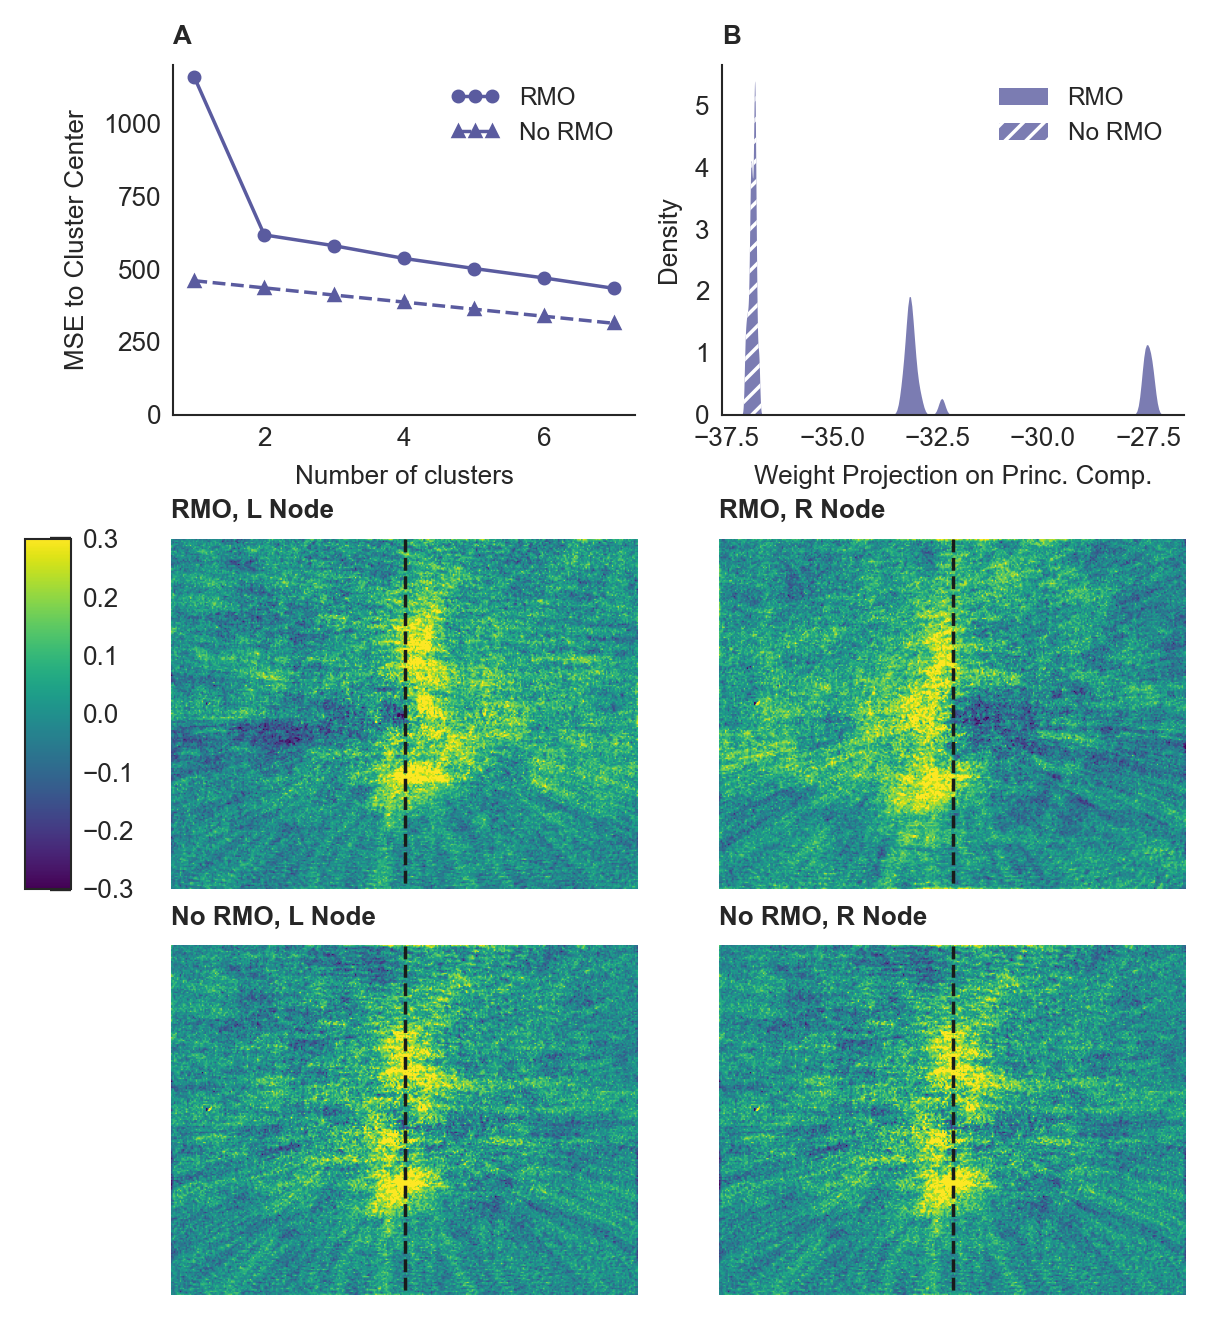

In [15]:

plt.style.use("plots.mplstyle")
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH))
n_gs = 20
n_horiz_colorbar = 2
gs = fig.add_gridspec(3, n_gs + n_horiz_colorbar)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

ax_shift = 0.035

ax_k_means = fig.add_subplot(gs[0, n_horiz_colorbar : n_gs // 2 + n_horiz_colorbar])

ax_k_means.plot(range(1, k_max), inertia["rmo"], "-o", label="RMO", c=colors[0], markersize=3)
ax_k_means.plot(range(1, k_max), inertia["linear"], "--^", label="No RMO", c=colors[0], markersize=3)

ax_k_means.set_ylim(bottom=0)

ax_k_means.set_xlabel("Number of clusters")
ax_k_means.set_ylabel("MSE to Cluster Center")

ax_k_means.legend()

ax_k_means.set_title("A", loc="left")

_pos = ax_k_means.get_position()
ax_k_means.set_position([_pos.x0 + 0.025, _pos.y0, _pos.width - 0.05, _pos.height])

ax_density = fig.add_subplot(gs[0, n_gs // 2 + n_horiz_colorbar :])

sns.kdeplot(
    reduced_weights_projection["rmo"][:, 0],
    ax=ax_density,
    label="RMO",
    fill=True,
    bw_adjust=0.05,
    color=colors[0],
    edgecolor=None,
    linewidth=0,
    alpha=0.8
)
kde = sns.kdeplot(
    reduced_weights_projection["linear"][:, 0],
    ax=ax_density,
    label="No RMO",
    fill=True,
    bw_adjust=0.5,
    color=colors[0],
    edgecolor=None,
    linewidth=0,
    alpha=0.8
)

kde.collections[1].set_hatch("////")

ax_density.set_xlabel("Weight Projection on Princ. Comp.")

ax_density.legend()

ax_density.set_title("B", loc="left")

_pos = ax_density.get_position()
ax_density.set_position([_pos.x0 + 0.025, _pos.y0, _pos.width - 0.05, _pos.height])

ax_colorbar = fig.add_subplot(gs[1, 0])
_p = ax_colorbar.get_position()
ax_colorbar.set_position([_p.x0, _p.y0 - ax_shift, _p.width, _p.height])

ax0 = fig.add_subplot(gs[1, n_horiz_colorbar : n_gs // 2 + n_horiz_colorbar])
ax1 = fig.add_subplot(gs[1, n_gs // 2 + n_horiz_colorbar :])
ax2 = fig.add_subplot(gs[2, n_horiz_colorbar : n_gs // 2 + n_horiz_colorbar])
ax3 = fig.add_subplot(gs[2, n_gs // 2 + n_horiz_colorbar :])

for _ax in [ax0, ax1, ax2, ax3]:
    # no left and bottom edges
    _ax.spines["left"].set_visible(False)
    _ax.spines["bottom"].set_visible(False)

cmap = "viridis"
#cmap = "hot"

vmin = -0.3
vmax = 0.3


left_pattern = patterns["rmo"][1, 0]
right_pattern = patterns["rmo"][1, 1]

_img = ax0.imshow(left_pattern, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(_img, cax=ax_colorbar, orientation="vertical")
ax0.set_title("RMO, L Node", loc="left")  # , fontweight="bold")
_img = ax1.imshow(right_pattern, vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(_img, ax=ax[0,1], orientation="horizontal")
ax1.set_title("RMO, R Node", loc="left")  # , fontweight="bold")

_p = ax0.get_position()
ax0.set_position([_p.x0, _p.y0 - ax_shift, _p.width, _p.height])

_p = ax1.get_position()
ax1.set_position([_p.x0, _p.y0 - ax_shift, _p.width, _p.height])

left_pattern = patterns["linear"][0, 0]
right_pattern = patterns["linear"][0, 1]

_img = ax2.imshow(left_pattern, vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(_img, ax=ax[1,0], orientation="horizontal")
ax2.set_title("No RMO, L Node", loc="left")  # , fontweight="bold")
_img = ax3.imshow(right_pattern, vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(_img, ax=ax[1,1], orientation="horizontal")
ax3.set_title("No RMO, R Node", loc="left")  # , fontweight="bold")

_p = ax2.get_position()
ax2.set_position([_p.x0, _p.y0 - ax_shift * 0.75, _p.width, _p.height])

_p = ax3.get_position()
ax3.set_position([_p.x0, _p.y0 - ax_shift * 0.75, _p.width, _p.height])

ax_colorbar.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)

for _ax in [ax0, ax1, ax2, ax3]:
    # no grid
    _ax.grid(False)
    _ax.axis("equal")
    _ax.vlines(SUBDIV_WIDTH // 2, 0, SUBDIV_HEIGHT - 1, linestyles="--", color="k")
    # no ticks
    _ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)

# fig.tight_layout()

fig.savefig("principal_component_learned_projection_weights.png", dpi=300)
fig.savefig("principal_component_learned_projection_weights.pdf", dpi=300, bbox_inches="tight")
plt.show()

31
0


/tmp/ipykernel_1290344/3475359216.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = _o


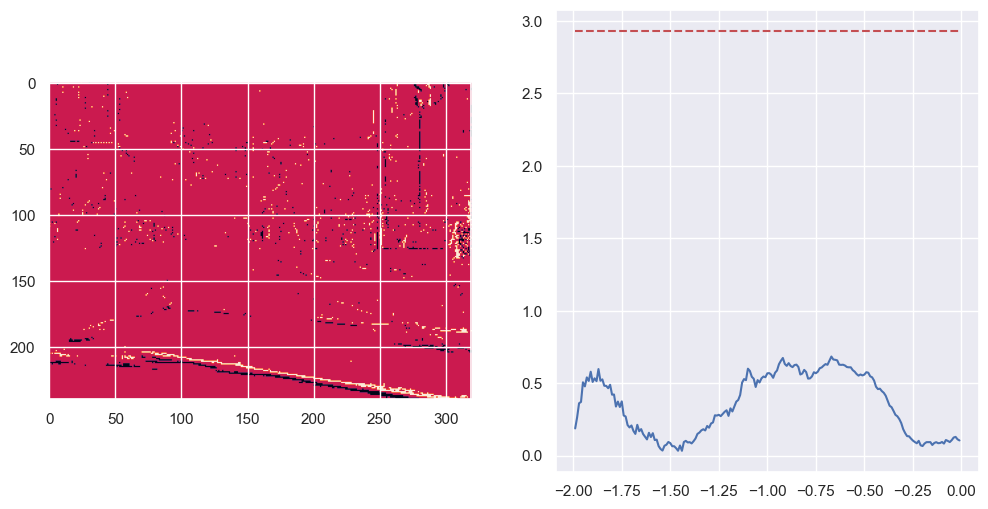

In [32]:
search_for = 0

while True:
    sample = np.random.randint(0, X_val.shape[0])
    if y_val[sample] == search_for:
        break

print(sample)
print(y_val[sample].detach().cpu().numpy())

steps = T_STEPS - 1

net.eval()
out = np.zeros((steps))
_o = 0.0
with torch.no_grad():
    for k in range(steps):
        img = torch.stack([X_val[sample,k,...], X_val[sample,k+1,...]], dim=0).float().to(device)
        #for i in range(_evts.shape[0]):
        #_o = net(img).detach().cpu().numpy()
        #_o = 0.95 * _o + 0.05 * (1. + np.tanh(0.5 * net(img).detach().cpu().numpy())) / 2.
        _o = 0.75 * _o + 0.25 * (net(img).detach().cpu().numpy() + net.out_th.detach().cpu().numpy())
        #_o = (1. + np.tanh(0.5 * net(img).detach().cpu().numpy())) / 2.
        out[k] = _o


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(X_val[sample,100,:,:].detach().numpy())

t_ax = (np.arange(1-T_STEPS,0) * md_val[sample]["dt"] / 1000)[:steps]
ax[1].plot(t_ax, out)

ax[1].hlines(net.out_th.detach().cpu().numpy(), t_ax[0], t_ax[-1], color="r", linestyle="--")
#ax[1].set_ylim(-.1,1.1)
#ax[1].set_ylim(-10.,10.)

plt.show()

In [94]:
net.eval()
net.reg

0.1

In [140]:
net.eval()
net.sigm.bias.detach().cpu().numpy()

array([-1.6511472], dtype=float32)

In [141]:
net.eval()
net.sigm.scale.detach().cpu().numpy()

array([0.47053856], dtype=float32)

In [142]:
net.eval()
net.out_scale.detach().cpu().numpy()

array([1.7137946], dtype=float32)

In [143]:
net.eval()
net.out_th.detach().cpu().numpy()

array([2.2176359], dtype=float32)